In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 01:53:37.343819


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v1" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v1"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1        143
dtype: int64
Total rows in df_review: 39974 



## 1) Using full dataset

In [5]:
# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Count number of reviews based on year and sentiment
sentiment_count = df_review.groupby([df_review["sentiment"], df_review["stay_date"].dt.year]).size().reset_index(name="count")
sentiment_count2 = sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sentiment_count2.columns.name = None
sentiment_count2

,negative,positive,Total
stay_date,,,
2022,1691,5560,7251
2023,5364,21375,26739
2024,1100,4741,5841
Total,8155,31676,39831


## 2) Topic Modeling

### a) Helper functions

In [6]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [7]:
# Filter positive and negative reviews and save into different dataframe
df_pos = df_review[df_review["sentiment"] == "positive"].reset_index(drop=True)
df_neg = df_review[df_review["sentiment"] == "negative"].reset_index(drop=True)

In [8]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████                                                                        | 1/9 [10:31<1:24:12, 631.53s/it]

Topic #1:
0.510*"I" + 0.477*"room" + 0.348*"hotel" + 0.213*"stay" + 0.188*"staff" + 0.181*"good" + 0.151*"location" + 0.148*"clean" + 0.090*"check" + 0.090*"get" + 0.089*"great" + 0.082*"also" + 0.080*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.070*"place" + 0.069*"night" + 0.067*"would" + 0.066*"friendly"

Topic #2:
-0.809*"I" + 0.311*"room" + 0.225*"good" + 0.208*"location" + 0.197*"hotel" + 0.141*"clean" + 0.104*"great" + 0.093*"staff" + 0.081*"small" + 0.067*"nice" + 0.065*"friendly" + 0.063*"stay" + 0.060*"near" + 0.055*"meet" + 0.040*"food" + 0.039*"helpful" + -0.037*"check" + 0.037*"place" + 0.036*"close" + 0.036*"comfortable"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████                                                               | 2/9 [21:12<1:14:20, 637.21s/it]

Topic #1:
0.512*"I" + 0.478*"room" + 0.346*"hotel" + 0.213*"stay" + 0.188*"staff" + 0.180*"good" + 0.150*"location" + 0.147*"clean" + 0.090*"check" + 0.090*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.066*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.337*"room" + 0.220*"good" + 0.199*"location" + 0.178*"hotel" + 0.145*"clean" + 0.099*"great" + 0.089*"staff" + 0.082*"small" + 0.066*"nice" + 0.062*"friendly" + 0.060*"near" + 0.059*"stay" + 0.054*"meet" + 0.038*"food" + 0.037*"helpful" + 0.036*"place" + 0.036*"comfortable" + 0.035*"close" + -0.035*"check"

Topic #3:
-0.679*"room" + 0.621*"hotel" + 0.162*"stay" + 0.162*"good" + 0.136*"location" + 0.090*"staff" + -0.070*"small" + 0.062*"great" + 0.059*"singapore" + 0.057*"friendly" + -0.052*"clean" + -0.052*"bed" + 0.049*"near" + 0.049*"food" + 0.046*"meet" + 0.044*"place" + -0.039*"check" + 0.036*"restaurant" + -0.033*"get" + 0.030*"helpful"

---

 33%|███████████████████████████                                                      | 3/9 [32:21<1:05:08, 651.48s/it]

Topic #1:
0.512*"I" + 0.477*"room" + 0.347*"hotel" + 0.213*"stay" + 0.187*"staff" + 0.181*"good" + 0.151*"location" + 0.147*"clean" + 0.090*"check" + 0.090*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.067*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.325*"room" + 0.225*"good" + 0.202*"location" + 0.184*"hotel" + 0.145*"clean" + 0.101*"great" + 0.092*"staff" + 0.080*"small" + 0.067*"nice" + 0.064*"friendly" + 0.064*"stay" + 0.061*"near" + 0.055*"meet" + 0.039*"food" + 0.038*"place" + 0.038*"helpful" + -0.036*"check" + 0.036*"comfortable" + 0.036*"close"

Topic #3:
-0.697*"room" + 0.584*"hotel" + 0.184*"good" + 0.177*"stay" + 0.147*"location" + 0.096*"staff" + -0.074*"small" + 0.067*"great" + 0.059*"friendly" + 0.058*"singapore" + 0.053*"near" + 0.052*"place" + 0.051*"food" + -0.050*"bed" + 0.048*"meet" + -0.047*"clean" + -0.042*"check" + 0.035*"restaurant" + -0.033*"get" + 0.033*"helpful"

Top

 44%|████████████████████████████████████▉                                              | 4/9 [43:09<54:10, 650.13s/it]

Topic #1:
0.512*"I" + 0.477*"room" + 0.346*"hotel" + 0.213*"stay" + 0.187*"staff" + 0.182*"good" + 0.151*"location" + 0.147*"clean" + 0.090*"check" + 0.090*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.067*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.325*"room" + 0.228*"good" + 0.201*"location" + 0.187*"hotel" + 0.145*"clean" + 0.099*"great" + 0.089*"staff" + 0.081*"small" + 0.066*"nice" + 0.062*"friendly" + 0.061*"stay" + 0.061*"near" + 0.055*"meet" + 0.039*"food" + 0.038*"place" + 0.037*"helpful" + -0.036*"check" + 0.036*"comfortable" + 0.036*"close"

Topic #3:
-0.694*"room" + 0.592*"hotel" + 0.179*"stay" + 0.178*"good" + 0.141*"location" + 0.091*"staff" + -0.074*"small" + 0.069*"great" + 0.058*"singapore" + 0.056*"friendly" + 0.052*"near" + 0.051*"place" + -0.051*"bed" + 0.050*"food" + -0.049*"clean" + 0.047*"meet" + -0.042*"check" + 0.035*"restaurant" + -0.032*"get" + -0.032*"book"

Topic

 56%|██████████████████████████████████████████████                                     | 5/9 [54:05<43:29, 652.32s/it]

Topic #1:
0.512*"I" + 0.477*"room" + 0.346*"hotel" + 0.213*"stay" + 0.187*"staff" + 0.182*"good" + 0.151*"location" + 0.147*"clean" + 0.090*"check" + 0.090*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.067*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.319*"room" + 0.227*"good" + 0.200*"location" + 0.198*"hotel" + 0.146*"clean" + 0.096*"great" + 0.095*"staff" + 0.080*"small" + 0.067*"nice" + 0.065*"friendly" + 0.061*"near" + 0.056*"stay" + 0.055*"meet" + 0.039*"food" + 0.038*"helpful" + 0.037*"place" + 0.036*"close" + 0.036*"comfortable" + 0.035*"restaurant"

Topic #3:
-0.693*"room" + 0.607*"hotel" + 0.166*"good" + 0.161*"stay" + 0.130*"location" + 0.095*"staff" + -0.074*"small" + 0.061*"great" + 0.058*"singapore" + 0.056*"friendly" + -0.052*"clean" + -0.052*"bed" + 0.050*"near" + 0.049*"food" + 0.046*"place" + 0.045*"meet" + -0.039*"check" + 0.035*"restaurant" + -0.032*"get" + 0.031*"helpful"


 67%|██████████████████████████████████████████████████████                           | 6/9 [1:05:07<32:47, 655.67s/it]

Topic #1:
0.512*"I" + 0.477*"room" + 0.346*"hotel" + 0.213*"stay" + 0.188*"staff" + 0.181*"good" + 0.151*"location" + 0.147*"clean" + 0.090*"check" + 0.089*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"nice" + 0.075*"time" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.066*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.318*"room" + 0.231*"good" + 0.198*"hotel" + 0.198*"location" + 0.146*"clean" + 0.096*"staff" + 0.095*"great" + 0.080*"small" + 0.067*"nice" + 0.066*"friendly" + 0.060*"near" + 0.057*"stay" + 0.054*"meet" + 0.039*"food" + 0.039*"helpful" + 0.037*"place" + 0.036*"close" + 0.035*"comfortable" + 0.035*"restaurant"

Topic #3:
-0.693*"room" + 0.607*"hotel" + 0.176*"good" + 0.159*"stay" + 0.124*"location" + 0.095*"staff" + -0.075*"small" + 0.058*"great" + 0.057*"singapore" + 0.056*"friendly" + -0.054*"clean" + -0.051*"bed" + 0.048*"food" + 0.048*"near" + 0.046*"place" + 0.043*"meet" + -0.038*"check" + 0.035*"restaurant" + -0.031*"get" + 0.031*"helpful"


 78%|███████████████████████████████████████████████████████████████                  | 7/9 [1:16:21<22:03, 661.53s/it]

Topic #1:
0.512*"I" + 0.477*"room" + 0.346*"hotel" + 0.213*"stay" + 0.188*"staff" + 0.181*"good" + 0.151*"location" + 0.147*"clean" + 0.090*"check" + 0.089*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"nice" + 0.075*"time" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.066*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.319*"room" + 0.231*"good" + 0.198*"location" + 0.198*"hotel" + 0.145*"clean" + 0.097*"staff" + 0.095*"great" + 0.080*"small" + 0.067*"nice" + 0.066*"friendly" + 0.060*"near" + 0.058*"stay" + 0.054*"meet" + 0.039*"helpful" + 0.039*"food" + 0.036*"place" + 0.035*"close" + 0.035*"comfortable" + -0.035*"check"

Topic #3:
-0.694*"room" + 0.606*"hotel" + 0.174*"good" + 0.160*"stay" + 0.125*"location" + 0.095*"staff" + -0.075*"small" + 0.058*"great" + 0.057*"singapore" + 0.056*"friendly" + -0.055*"clean" + -0.050*"bed" + 0.048*"food" + 0.048*"near" + 0.046*"place" + 0.043*"meet" + -0.037*"check" + 0.035*"restaurant" + 0.031*"helpful" + -0.030*"get"

Top

 89%|████████████████████████████████████████████████████████████████████████         | 8/9 [1:27:42<11:07, 667.70s/it]

Topic #1:
0.512*"I" + 0.477*"room" + 0.346*"hotel" + 0.213*"stay" + 0.188*"staff" + 0.181*"good" + 0.151*"location" + 0.147*"clean" + 0.090*"check" + 0.089*"get" + 0.088*"great" + 0.082*"also" + 0.080*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.066*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.319*"room" + 0.231*"good" + 0.201*"location" + 0.198*"hotel" + 0.142*"clean" + 0.097*"great" + 0.096*"staff" + 0.080*"small" + 0.066*"friendly" + 0.065*"nice" + 0.059*"near" + 0.059*"stay" + 0.053*"meet" + 0.039*"helpful" + 0.039*"food" + 0.035*"close" + 0.035*"comfortable" + -0.035*"check" + 0.035*"place"

Topic #3:
-0.693*"room" + 0.607*"hotel" + 0.174*"good" + 0.161*"stay" + 0.125*"location" + 0.096*"staff" + -0.075*"small" + -0.059*"clean" + 0.058*"great" + 0.057*"singapore" + 0.056*"friendly" + -0.050*"bed" + 0.048*"food" + 0.047*"near" + 0.045*"place" + 0.042*"meet" + -0.037*"check" + 0.034*"restaurant" + 0.031*"helpful" + -0.031*"get"

Top

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:39:09<00:00, 661.10s/it]


Topic #1:
0.512*"I" + 0.477*"room" + 0.346*"hotel" + 0.213*"stay" + 0.188*"staff" + 0.181*"good" + 0.151*"location" + 0.148*"clean" + 0.090*"check" + 0.089*"get" + 0.088*"great" + 0.082*"also" + 0.079*"small" + 0.075*"time" + 0.075*"nice" + 0.072*"bed" + 0.069*"place" + 0.069*"night" + 0.066*"would" + 0.066*"friendly"

Topic #2:
-0.808*"I" + 0.319*"room" + 0.231*"good" + 0.202*"location" + 0.198*"hotel" + 0.144*"clean" + 0.097*"great" + 0.096*"staff" + 0.079*"small" + 0.066*"friendly" + 0.065*"nice" + 0.059*"near" + 0.059*"stay" + 0.053*"meet" + 0.039*"helpful" + 0.038*"food" + 0.035*"comfortable" + 0.035*"close" + 0.035*"place" + -0.035*"check"

Topic #3:
-0.694*"room" + 0.606*"hotel" + 0.173*"good" + 0.161*"stay" + 0.127*"location" + 0.095*"staff" + -0.074*"small" + 0.060*"great" + -0.059*"clean" + 0.057*"singapore" + 0.056*"friendly" + -0.050*"bed" + 0.048*"food" + 0.047*"near" + 0.046*"place" + 0.043*"meet" + -0.037*"check" + 0.034*"restaurant" + 0.031*"helpful" + -0.030*"get"

Top

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:13<01:46, 13.37s/it]

Topic #1:
0.049*"room" + 0.034*"I" + 0.013*"hotel" + 0.012*"clean" + 0.011*"bed" + 0.010*"small" + 0.010*"stay" + 0.009*"get" + 0.009*"check" + 0.008*"good" + 0.008*"like" + 0.008*"location" + 0.007*"place" + 0.007*"also" + 0.007*"night" + 0.006*"time" + 0.006*"need" + 0.006*"well" + 0.006*"one" + 0.006*"bathroom"

Topic #2:
0.058*"location" + 0.045*"good" + 0.042*"staff" + 0.033*"hotel" + 0.027*"great" + 0.022*"stay" + 0.022*"clean" + 0.020*"friendly" + 0.015*"nice" + 0.015*"helpful" + 0.015*"room" + 0.013*"near" + 0.010*"I" + 0.010*"meet" + 0.009*"restaurant" + 0.008*"excellent" + 0.008*"service" + 0.008*"place" + 0.008*"close" + 0.008*"facility"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:28<01:39, 14.28s/it]

Topic #1:
0.055*"I" + 0.028*"room" + 0.024*"hotel" + 0.024*"stay" + 0.022*"staff" + 0.013*"check" + 0.009*"time" + 0.009*"would" + 0.008*"like" + 0.007*"clean" + 0.007*"service" + 0.007*"book" + 0.007*"great" + 0.006*"friendly" + 0.006*"helpful" + 0.006*"amazing" + 0.006*"day" + 0.006*"good" + 0.006*"really" + 0.006*"make"

Topic #2:
0.082*"location" + 0.056*"good" + 0.038*"staff" + 0.030*"clean" + 0.029*"hotel" + 0.028*"great" + 0.022*"room" + 0.022*"near" + 0.021*"meet" + 0.021*"friendly" + 0.018*"nice" + 0.016*"stay" + 0.016*"place" + 0.015*"helpful" + 0.014*"close" + 0.012*"food" + 0.012*"restaurant" + 0.010*"meet_station" + 0.010*"convenient" + 0.008*"facility"

Topic #3:
0.050*"room" + 0.018*"good" + 0.017*"bed" + 0.014*"clean" + 0.014*"hotel" + 0.012*"small" + 0.012*"location" + 0.009*"I" + 0.009*"bathroom" + 0.009*"get" + 0.008*"great" + 0.008*"pool" + 0.008*"nice" + 0.007*"also" + 0.007*"shower" + 0.006*"breakfast" + 0.006*"well" + 0.006*"like" + 0.006*"toilet" + 0.006*"night"

 33%|████████████████████████████                                                        | 3/9 [00:42<01:25, 14.20s/it]

Topic #1:
0.049*"room" + 0.023*"I" + 0.021*"bed" + 0.013*"bathroom" + 0.011*"small" + 0.011*"toilet" + 0.011*"shower" + 0.010*"get" + 0.010*"clean" + 0.008*"like" + 0.008*"night" + 0.008*"door" + 0.008*"also" + 0.008*"one" + 0.008*"need" + 0.008*"well" + 0.008*"sleep" + 0.007*"use" + 0.007*"share" + 0.007*"towel"

Topic #2:
0.027*"pool" + 0.024*"room" + 0.021*"place" + 0.014*"great" + 0.014*"nice" + 0.013*"ok" + 0.013*"hotel" + 0.013*"view" + 0.013*"price" + 0.012*"good" + 0.010*"get" + 0.010*"walk" + 0.010*"location" + 0.009*"love" + 0.008*"close" + 0.008*"well" + 0.007*"stay" + 0.007*"clean" + 0.007*"like" + 0.007*"kitchen"

Topic #3:
0.059*"location" + 0.044*"good" + 0.034*"room" + 0.032*"staff" + 0.031*"hotel" + 0.027*"clean" + 0.023*"great" + 0.019*"stay" + 0.017*"friendly" + 0.016*"nice" + 0.014*"near" + 0.014*"meet" + 0.012*"helpful" + 0.011*"place" + 0.010*"comfortable" + 0.010*"close" + 0.009*"restaurant" + 0.009*"breakfast" + 0.008*"food" + 0.008*"facility"

Topic #4:
0.062*"

 44%|█████████████████████████████████████▎                                              | 4/9 [01:02<01:22, 16.47s/it]

Topic #1:
0.039*"stay" + 0.033*"staff" + 0.029*"I" + 0.028*"hotel" + 0.017*"room" + 0.016*"great" + 0.012*"friendly" + 0.012*"helpful" + 0.010*"service" + 0.010*"would" + 0.010*"clean" + 0.008*"amazing" + 0.008*"love" + 0.008*"time" + 0.008*"make" + 0.008*"check" + 0.007*"nice" + 0.007*"excellent" + 0.007*"comfortable" + 0.007*"definitely"

Topic #2:
0.079*"I" + 0.038*"room" + 0.019*"check" + 0.014*"get" + 0.012*"like" + 0.011*"time" + 0.008*"one" + 0.008*"day" + 0.008*"hotel" + 0.008*"book" + 0.008*"night" + 0.007*"need" + 0.007*"use" + 0.007*"go" + 0.007*"also" + 0.007*"even" + 0.006*"staff" + 0.006*"well" + 0.006*"smell" + 0.006*"toilet"

Topic #3:
0.031*"meet" + 0.030*"location" + 0.028*"near" + 0.024*"hotel" + 0.023*"place" + 0.019*"close" + 0.017*"food" + 0.015*"station" + 0.014*"walk" + 0.014*"good" + 0.013*"restaurant" + 0.012*"meet_station" + 0.012*"area" + 0.012*"stay" + 0.011*"easy" + 0.011*"room" + 0.011*"nearby" + 0.010*"bus" + 0.010*"great" + 0.010*"around"

Topic #4:
0.0

 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:22<01:11, 17.91s/it]

Topic #1:
0.116*"I" + 0.040*"stay" + 0.022*"like" + 0.022*"make" + 0.016*"feel" + 0.016*"night" + 0.015*"room" + 0.014*"hotel" + 0.013*"thank" + 0.012*"staff" + 0.012*"day" + 0.011*"love" + 0.011*"time" + 0.010*"nothing" + 0.010*"experience" + 0.009*"really" + 0.009*"would" + 0.009*"sleep" + 0.009*"bed" + 0.008*"welcome"

Topic #2:
0.057*"room" + 0.016*"clean" + 0.015*"I" + 0.015*"bed" + 0.012*"small" + 0.011*"hotel" + 0.010*"bathroom" + 0.010*"staff" + 0.009*"stay" + 0.009*"also" + 0.008*"good" + 0.007*"shower" + 0.007*"get" + 0.007*"toilet" + 0.007*"provide" + 0.007*"like" + 0.007*"need" + 0.006*"space" + 0.006*"one" + 0.005*"towel"

Topic #3:
0.048*"check" + 0.027*"room" + 0.019*"I" + 0.018*"get" + 0.012*"early" + 0.011*"pool" + 0.009*"hotel" + 0.009*"hour" + 0.009*"take" + 0.009*"need" + 0.008*"door" + 0.008*"go" + 0.008*"late" + 0.008*"pm" + 0.007*"view" + 0.007*"reception" + 0.007*"bed" + 0.007*"leave" + 0.006*"well" + 0.006*"come"

Topic #4:
0.036*"location" + 0.033*"near" + 0.0

 67%|████████████████████████████████████████████████████████                            | 6/9 [01:41<00:54, 18.22s/it]

Topic #1:
0.081*"location" + 0.060*"good" + 0.029*"hotel" + 0.029*"meet" + 0.028*"near" + 0.026*"room" + 0.022*"clean" + 0.018*"staff" + 0.017*"close" + 0.017*"restaurant" + 0.015*"food" + 0.013*"great" + 0.013*"meet_station" + 0.013*"breakfast" + 0.013*"nice" + 0.011*"place" + 0.011*"nearby" + 0.010*"walk" + 0.010*"convenient" + 0.010*"station"

Topic #2:
0.043*"I" + 0.029*"place" + 0.025*"like" + 0.023*"hotel" + 0.020*"stay" + 0.018*"room" + 0.017*"recommend" + 0.016*"love" + 0.016*"really" + 0.012*"clean" + 0.012*"nice" + 0.012*"would" + 0.010*"japan_bear" + 0.009*"good" + 0.008*"location" + 0.008*"also" + 0.008*"well" + 0.007*"go" + 0.007*"private" + 0.007*"right"

Topic #3:
0.109*"I" + 0.034*"check" + 0.023*"time" + 0.018*"room" + 0.017*"hotel" + 0.015*"book" + 0.015*"hostel" + 0.014*"go" + 0.013*"day" + 0.012*"get" + 0.012*"staff" + 0.010*"night" + 0.010*"stay" + 0.010*"early" + 0.010*"one" + 0.009*"like" + 0.008*"reception" + 0.008*"say" + 0.007*"give" + 0.007*"ask"

Topic #4:
0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [02:00<00:36, 18.38s/it]

Topic #1:
0.078*"room" + 0.030*"bed" + 0.019*"small" + 0.016*"clean" + 0.015*"I" + 0.014*"bathroom" + 0.012*"get" + 0.010*"shower" + 0.009*"toilet" + 0.009*"need" + 0.008*"smell" + 0.008*"ok" + 0.008*"good" + 0.008*"quite" + 0.007*"also" + 0.007*"night" + 0.007*"sleep" + 0.007*"bit" + 0.007*"floor" + 0.007*"one"

Topic #2:
0.055*"location" + 0.031*"hotel" + 0.027*"meet" + 0.027*"near" + 0.025*"great" + 0.023*"staff" + 0.022*"good" + 0.020*"close" + 0.018*"restaurant" + 0.016*"food" + 0.015*"room" + 0.014*"clean" + 0.014*"stay" + 0.013*"meet_station" + 0.013*"friendly" + 0.012*"convenient" + 0.012*"place" + 0.012*"helpful" + 0.011*"area" + 0.011*"nearby"

Topic #3:
0.023*"room" + 0.020*"apartment" + 0.018*"share" + 0.017*"space" + 0.014*"shower" + 0.014*"work" + 0.011*"toilet" + 0.010*"private" + 0.010*"hot" + 0.009*"good" + 0.009*"bathroom" + 0.008*"bad" + 0.008*"son" + 0.008*"available" + 0.007*"location" + 0.007*"get" + 0.007*"small" + 0.007*"noise" + 0.007*"ac" + 0.007*"communal"

T

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:19<00:18, 18.74s/it]

Topic #1:
0.057*"I" + 0.037*"stay" + 0.035*"pool" + 0.032*"hotel" + 0.025*"love" + 0.023*"view" + 0.021*"amazing" + 0.020*"beautiful" + 0.019*"time" + 0.014*"like" + 0.014*"singapore" + 0.013*"great" + 0.013*"enjoy" + 0.012*"lovely" + 0.012*"excellent" + 0.011*"staff" + 0.011*"service" + 0.010*"definitely" + 0.010*"would" + 0.010*"thank"

Topic #2:
0.048*"location" + 0.032*"food" + 0.029*"close" + 0.027*"meet" + 0.026*"restaurant" + 0.026*"place" + 0.025*"good" + 0.022*"great" + 0.022*"hotel" + 0.022*"nearby" + 0.020*"near" + 0.018*"stay" + 0.017*"lot" + 0.016*"area" + 0.015*"hostel" + 0.014*"many" + 0.014*"convenient" + 0.014*"meet_station" + 0.012*"nice" + 0.012*"clean"

Topic #3:
0.080*"I" + 0.055*"check" + 0.033*"staff" + 0.017*"reception" + 0.016*"room" + 0.016*"time" + 0.013*"help" + 0.013*"get" + 0.012*"early" + 0.010*"need" + 0.009*"day" + 0.009*"ask" + 0.009*"request" + 0.008*"guest" + 0.008*"call" + 0.008*"take" + 0.008*"hour" + 0.008*"really" + 0.007*"hotel" + 0.007*"one"

T

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:39<00:00, 17.71s/it]

Topic #1:
0.134*"location" + 0.052*"near" + 0.043*"meet" + 0.040*"great" + 0.039*"good" + 0.029*"close" + 0.023*"hotel" + 0.022*"meet_station" + 0.022*"restaurant" + 0.021*"clean" + 0.019*"staff" + 0.018*"convenient" + 0.018*"room" + 0.015*"station" + 0.012*"nearby" + 0.011*"also" + 0.011*"nice" + 0.010*"food" + 0.010*"stay" + 0.010*"bus_stop"

Topic #2:
0.108*"nice" + 0.058*"place" + 0.045*"love" + 0.044*"clean" + 0.040*"stay" + 0.038*"everything" + 0.036*"room" + 0.031*"hotel" + 0.030*"good" + 0.021*"location" + 0.020*"I" + 0.014*"recommend" + 0.013*"come" + 0.013*"spacious" + 0.013*"pool" + 0.012*"really" + 0.012*"family" + 0.012*"perfect" + 0.011*"amazing" + 0.011*"definitely"

Topic #3:
0.086*"staff" + 0.067*"good" + 0.055*"location" + 0.045*"friendly" + 0.035*"great" + 0.033*"helpful" + 0.031*"room" + 0.029*"hotel" + 0.027*"clean" + 0.026*"stay" + 0.019*"excellent" + 0.018*"facility" + 0.018*"service" + 0.015*"comfortable" + 0.011*"breakfast" + 0.011*"value_money" + 0.010*"I" + 0

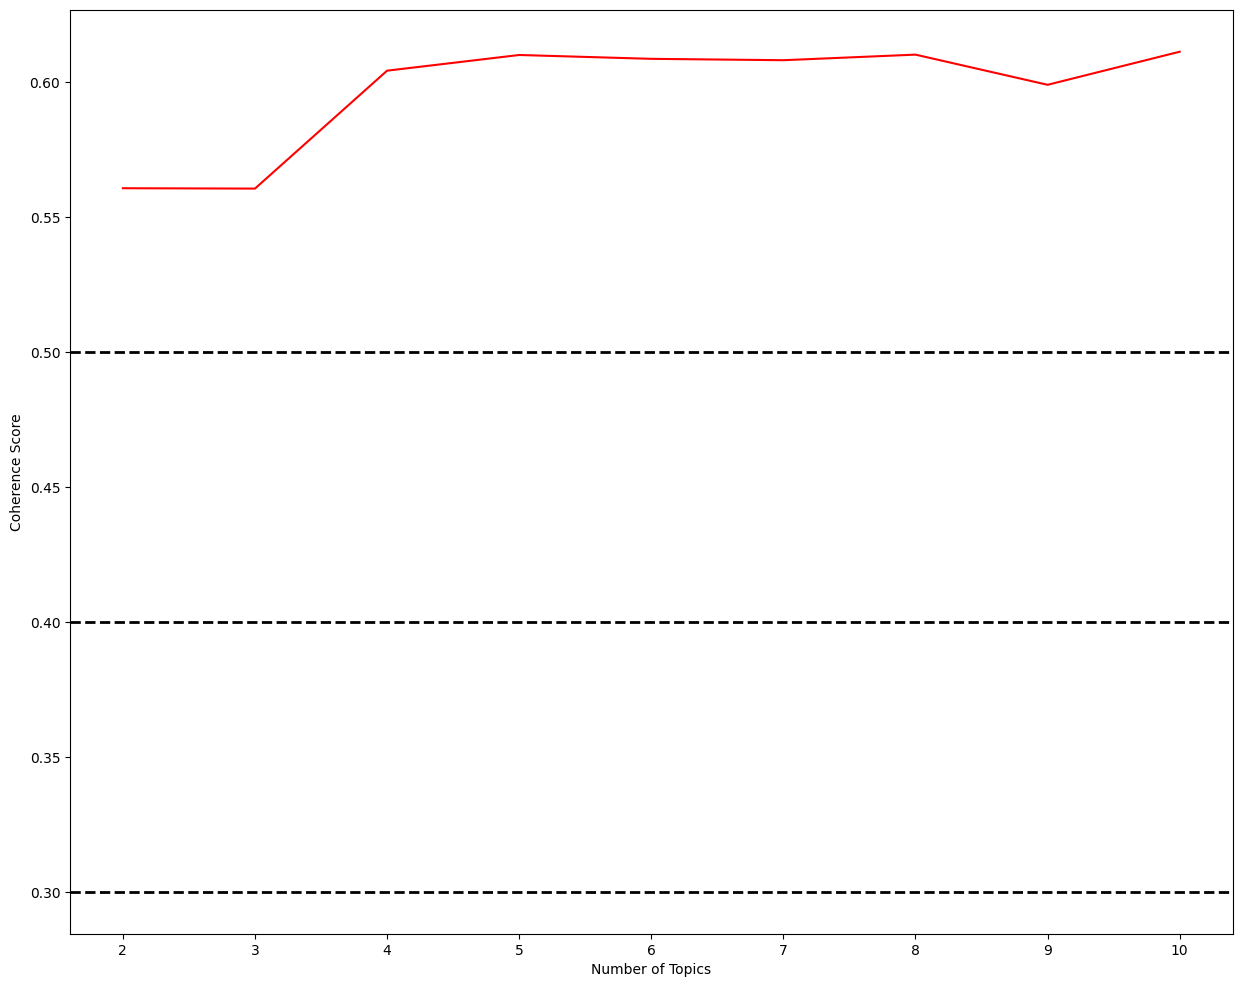

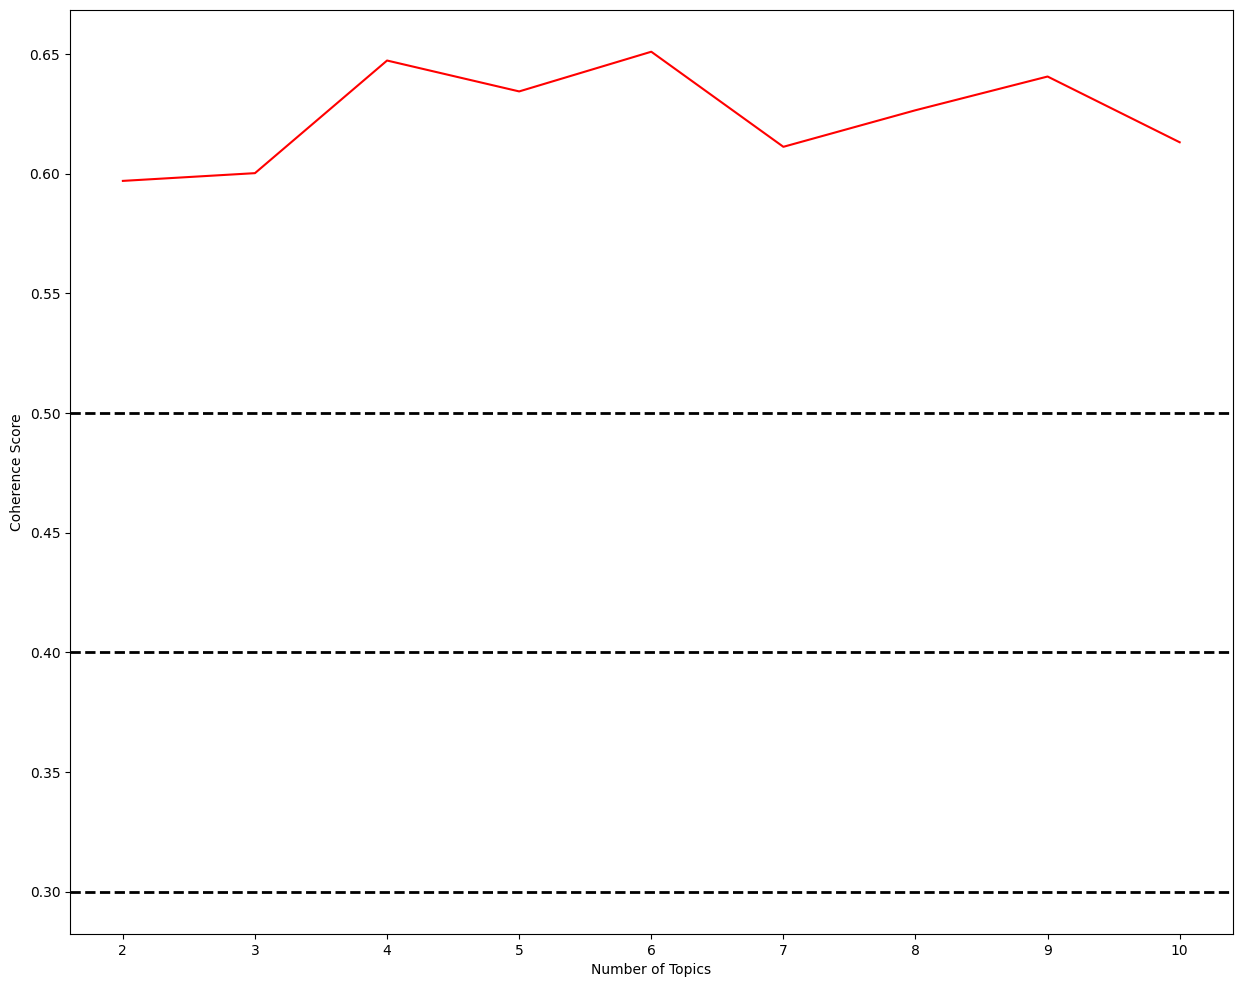


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [02:18<18:26, 138.33s/it]

Topic #1:
0.684*"I" + 0.475*"room" + 0.253*"hotel" + 0.131*"staff" + 0.126*"check" + 0.123*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.076*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.672*"room" + 0.660*"I" + -0.139*"hotel" + -0.117*"small" + -0.084*"clean" + -0.064*"good" + -0.058*"bathroom" + -0.055*"smell" + -0.054*"bed" + -0.052*"location" + -0.049*"get" + -0.048*"staff" + -0.048*"stay" + -0.043*"shower" + -0.041*"toilet" + -0.040*"dirty" + -0.036*"well" + -0.036*"night" + -0.035*"water" + -0.034*"bad"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [04:38<16:14, 139.18s/it]

Topic #1:
0.685*"I" + 0.475*"room" + 0.253*"hotel" + 0.131*"staff" + 0.126*"check" + 0.123*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.076*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"even" + 0.061*"good" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.680*"room" + 0.657*"I" + -0.126*"hotel" + -0.117*"small" + -0.083*"clean" + -0.062*"good" + -0.056*"bathroom" + -0.054*"smell" + -0.054*"bed" + -0.050*"location" + -0.048*"get" + -0.047*"staff" + -0.043*"stay" + -0.040*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.035*"night" + -0.035*"well" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.808*"hotel" + 0.408*"room" + 0.197*"I" + -0.181*"staff" + -0.107*"stay" + -0.080*"good" + -0.072*"breakfast" + -0.064*"guest" + -0.064*"location" + -0.053*"star" + -0.052*"need" + -0.052*"check" + -0.051*"service" + -0.049*"well" + -0.046*"price" + -0.046*"one" + -0.044*"food" + -0.043*"singapore" + -0.041*"like" + -0.038*"bad"

----------

 33%|███████████████████████████▋                                                       | 3/9 [06:59<13:59, 139.99s/it]

Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.122*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"even" + 0.061*"good" + 0.058*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.658*"I" + -0.132*"hotel" + -0.116*"small" + -0.083*"clean" + -0.062*"good" + -0.056*"bathroom" + -0.054*"smell" + -0.053*"bed" + -0.050*"location" + -0.048*"staff" + -0.048*"get" + -0.043*"stay" + -0.040*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.035*"well" + -0.034*"night" + -0.034*"water" + -0.032*"bad"

Topic #3:
-0.787*"hotel" + 0.424*"room" + -0.204*"staff" + 0.200*"I" + -0.114*"stay" + -0.082*"good" + -0.071*"breakfast" + -0.070*"guest" + -0.067*"check" + -0.064*"location" + -0.057*"need" + -0.055*"service" + -0.052*"star" + -0.048*"well" + -0.047*"one" + -0.046*"price" + -0.044*"singapore" + -0.044*"food" + -0.042*"like" + -0.041*"bad"

Topic #4:


 44%|████████████████████████████████████▉                                              | 4/9 [09:23<11:48, 141.60s/it]

Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.123*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.658*"I" + -0.133*"hotel" + -0.116*"small" + -0.083*"clean" + -0.062*"good" + -0.055*"bathroom" + -0.054*"smell" + -0.052*"bed" + -0.050*"location" + -0.048*"staff" + -0.047*"get" + -0.042*"stay" + -0.039*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.034*"well" + -0.034*"night" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.806*"hotel" + 0.417*"room" + 0.193*"I" + -0.179*"staff" + -0.104*"stay" + -0.079*"good" + -0.072*"breakfast" + -0.066*"guest" + -0.062*"location" + -0.054*"check" + -0.053*"star" + -0.053*"need" + -0.052*"service" + -0.050*"price" + -0.046*"well" + -0.044*"singapore" + -0.041*"one" + -0.041*"food" + -0.040*"like" + -0.038*"bad"

Topic #4:


 56%|██████████████████████████████████████████████                                     | 5/9 [11:47<09:31, 142.76s/it]

Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.123*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.658*"I" + -0.133*"hotel" + -0.116*"small" + -0.083*"clean" + -0.062*"good" + -0.055*"bathroom" + -0.054*"smell" + -0.052*"bed" + -0.050*"location" + -0.048*"staff" + -0.047*"get" + -0.043*"stay" + -0.039*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.034*"well" + -0.034*"night" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.805*"hotel" + 0.416*"room" + 0.193*"I" + -0.184*"staff" + -0.105*"stay" + -0.080*"good" + -0.073*"breakfast" + -0.066*"guest" + -0.062*"location" + -0.053*"star" + -0.053*"need" + -0.052*"check" + -0.052*"service" + -0.050*"price" + -0.046*"well" + -0.043*"singapore" + -0.041*"one" + -0.041*"food" + -0.040*"like" + -0.038*"bad"

Topic #4:


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [14:13<07:11, 143.88s/it]

Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.122*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.657*"I" + -0.133*"hotel" + -0.115*"small" + -0.084*"clean" + -0.062*"good" + -0.055*"bathroom" + -0.055*"smell" + -0.052*"bed" + -0.050*"location" + -0.048*"staff" + -0.047*"get" + -0.042*"stay" + -0.039*"shower" + -0.039*"dirty" + -0.039*"toilet" + -0.035*"well" + -0.034*"night" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.804*"hotel" + 0.415*"room" + 0.194*"I" + -0.188*"staff" + -0.106*"stay" + -0.078*"good" + -0.073*"breakfast" + -0.067*"guest" + -0.061*"location" + -0.057*"check" + -0.053*"star" + -0.052*"service" + -0.052*"need" + -0.050*"price" + -0.046*"well" + -0.043*"singapore" + -0.042*"one" + -0.040*"food" + -0.038*"like" + -0.037*"bad"

Topic #4:


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [17:09<05:08, 154.32s/it]

Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.122*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.657*"I" + -0.133*"hotel" + -0.115*"small" + -0.083*"clean" + -0.062*"good" + -0.055*"bathroom" + -0.054*"smell" + -0.053*"bed" + -0.050*"location" + -0.048*"staff" + -0.047*"get" + -0.043*"stay" + -0.040*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.035*"well" + -0.034*"night" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.805*"hotel" + 0.416*"room" + 0.194*"I" + -0.187*"staff" + -0.104*"stay" + -0.078*"good" + -0.071*"breakfast" + -0.066*"guest" + -0.062*"location" + -0.057*"check" + -0.053*"star" + -0.051*"need" + -0.051*"service" + -0.050*"price" + -0.045*"well" + -0.043*"singapore" + -0.043*"one" + -0.039*"food" + -0.039*"like" + -0.037*"bad"

Topic #4:


 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [20:16<02:44, 164.59s/it]

Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.122*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.657*"I" + -0.133*"hotel" + -0.115*"small" + -0.083*"clean" + -0.061*"good" + -0.055*"bathroom" + -0.055*"smell" + -0.053*"bed" + -0.050*"location" + -0.048*"staff" + -0.047*"get" + -0.043*"stay" + -0.040*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.035*"well" + -0.035*"night" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.805*"hotel" + 0.416*"room" + 0.194*"I" + -0.186*"staff" + -0.107*"stay" + -0.079*"good" + -0.071*"breakfast" + -0.066*"guest" + -0.062*"location" + -0.055*"check" + -0.053*"star" + -0.050*"need" + -0.050*"service" + -0.050*"price" + -0.046*"well" + -0.043*"one" + -0.043*"singapore" + -0.039*"like" + -0.039*"food" + -0.037*"bad"

Topic #4:


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [22:54<00:00, 152.69s/it]


Topic #1:
0.685*"I" + 0.476*"room" + 0.254*"hotel" + 0.131*"staff" + 0.126*"check" + 0.122*"stay" + 0.089*"get" + 0.085*"time" + 0.078*"night" + 0.077*"book" + 0.075*"clean" + 0.075*"one" + 0.071*"go" + 0.070*"ask" + 0.067*"bed" + 0.061*"good" + 0.061*"even" + 0.059*"small" + 0.055*"say" + 0.055*"day"

Topic #2:
-0.679*"room" + 0.657*"I" + -0.133*"hotel" + -0.114*"small" + -0.083*"clean" + -0.061*"good" + -0.055*"bathroom" + -0.055*"smell" + -0.053*"bed" + -0.050*"location" + -0.048*"staff" + -0.047*"get" + -0.043*"stay" + -0.040*"shower" + -0.039*"toilet" + -0.039*"dirty" + -0.035*"well" + -0.035*"night" + -0.033*"water" + -0.032*"bad"

Topic #3:
-0.807*"hotel" + 0.415*"room" + 0.193*"I" + -0.183*"staff" + -0.107*"stay" + -0.078*"good" + -0.071*"breakfast" + -0.066*"guest" + -0.061*"location" + -0.053*"star" + -0.051*"need" + -0.051*"check" + -0.050*"price" + -0.050*"service" + -0.046*"well" + -0.044*"one" + -0.043*"singapore" + -0.040*"like" + -0.039*"food" + -0.037*"bad"

Topic #4:


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:08<01:07,  8.47s/it]

Topic #1:
0.053*"I" + 0.049*"room" + 0.019*"hotel" + 0.017*"staff" + 0.014*"check" + 0.011*"time" + 0.010*"get" + 0.009*"stay" + 0.009*"clean" + 0.009*"bed" + 0.009*"would" + 0.008*"small" + 0.008*"breakfast" + 0.008*"night" + 0.008*"book" + 0.008*"could" + 0.007*"like" + 0.007*"service" + 0.006*"even" + 0.006*"good"

Topic #2:
0.042*"room" + 0.017*"hotel" + 0.017*"small" + 0.016*"I" + 0.014*"bathroom" + 0.014*"nothing" + 0.012*"stay" + 0.012*"shower" + 0.010*"bit" + 0.010*"clean" + 0.009*"toilet" + 0.009*"good" + 0.009*"smell" + 0.009*"bed" + 0.008*"one" + 0.007*"also" + 0.007*"get" + 0.007*"need" + 0.007*"water" + 0.007*"dirty"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:15<00:54,  7.74s/it]

Topic #1:
0.052*"room" + 0.042*"I" + 0.020*"hotel" + 0.013*"check" + 0.013*"small" + 0.013*"staff" + 0.011*"clean" + 0.010*"get" + 0.010*"stay" + 0.009*"time" + 0.007*"service" + 0.007*"need" + 0.007*"would" + 0.007*"one" + 0.007*"night" + 0.006*"day" + 0.006*"go" + 0.006*"breakfast" + 0.006*"book" + 0.006*"even"

Topic #2:
0.057*"I" + 0.030*"room" + 0.028*"bed" + 0.021*"shower" + 0.015*"bathroom" + 0.015*"hotel" + 0.014*"toilet" + 0.013*"like" + 0.013*"stay" + 0.011*"dirty" + 0.010*"small" + 0.009*"floor" + 0.008*"sleep" + 0.008*"could" + 0.008*"night" + 0.007*"smell" + 0.007*"would" + 0.007*"price" + 0.007*"wall" + 0.007*"book"

Topic #3:
0.040*"room" + 0.027*"nothing" + 0.017*"good" + 0.016*"hotel" + 0.015*"bit" + 0.013*"small" + 0.012*"staff" + 0.011*"stay" + 0.011*"breakfast" + 0.010*"bathroom" + 0.010*"location" + 0.010*"price" + 0.009*"night" + 0.009*"could" + 0.008*"little" + 0.008*"area" + 0.008*"expensive" + 0.008*"smell" + 0.008*"noise" + 0.007*"clean"

---------------------

 33%|████████████████████████████                                                        | 3/9 [00:22<00:45,  7.52s/it]

Topic #1:
0.037*"room" + 0.018*"bit" + 0.016*"I" + 0.012*"time" + 0.011*"check" + 0.011*"bathroom" + 0.011*"night" + 0.011*"hotel" + 0.010*"little" + 0.009*"noise" + 0.009*"get" + 0.009*"toilet" + 0.009*"staff" + 0.009*"door" + 0.008*"work" + 0.008*"area" + 0.008*"smell" + 0.008*"day" + 0.008*"use" + 0.008*"shower"

Topic #2:
0.074*"room" + 0.040*"I" + 0.021*"small" + 0.015*"bed" + 0.014*"hotel" + 0.012*"stay" + 0.011*"shower" + 0.010*"get" + 0.009*"bathroom" + 0.009*"night" + 0.008*"book" + 0.008*"could" + 0.007*"toilet" + 0.007*"one" + 0.007*"time" + 0.007*"staff" + 0.007*"bad" + 0.006*"water" + 0.006*"check" + 0.006*"space"

Topic #3:
0.090*"nothing" + 0.041*"room" + 0.032*"small" + 0.022*"price" + 0.019*"breakfast" + 0.017*"facility" + 0.014*"expensive" + 0.012*"good" + 0.012*"bathroom" + 0.011*"high" + 0.011*"need" + 0.011*"size" + 0.011*"everything" + 0.010*"cleanliness" + 0.009*"quite" + 0.009*"place" + 0.009*"like" + 0.008*"improve" + 0.008*"ok" + 0.007*"cold"

Topic #4:
0.050*

 44%|█████████████████████████████████████▎                                              | 4/9 [00:29<00:36,  7.28s/it]

Topic #1:
0.041*"I" + 0.032*"hotel" + 0.032*"room" + 0.014*"stay" + 0.012*"get" + 0.012*"check" + 0.010*"staff" + 0.009*"would" + 0.009*"book" + 0.008*"time" + 0.008*"could" + 0.007*"bed" + 0.007*"make" + 0.007*"one" + 0.007*"place" + 0.006*"night" + 0.006*"day" + 0.006*"even" + 0.006*"also" + 0.006*"use"

Topic #2:
0.084*"I" + 0.041*"room" + 0.016*"check" + 0.014*"hotel" + 0.013*"staff" + 0.011*"one" + 0.011*"time" + 0.010*"stay" + 0.010*"get" + 0.009*"go" + 0.009*"give" + 0.009*"book" + 0.009*"night" + 0.009*"ask" + 0.008*"bed" + 0.008*"would" + 0.007*"good" + 0.007*"could" + 0.007*"like" + 0.007*"say"

Topic #3:
0.027*"room" + 0.024*"staff" + 0.015*"I" + 0.014*"clean" + 0.012*"stay" + 0.011*"hotel" + 0.010*"night" + 0.009*"time" + 0.009*"check" + 0.009*"get" + 0.008*"bad" + 0.008*"service" + 0.008*"work" + 0.008*"door" + 0.008*"could" + 0.007*"reception" + 0.007*"floor" + 0.007*"day" + 0.007*"well" + 0.007*"cold"

Topic #4:
0.081*"room" + 0.031*"small" + 0.020*"bathroom" + 0.020*"sh

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:37<00:29,  7.29s/it]

Topic #1:
0.066*"I" + 0.054*"room" + 0.021*"hotel" + 0.012*"check" + 0.011*"get" + 0.011*"staff" + 0.011*"breakfast" + 0.010*"give" + 0.010*"time" + 0.010*"book" + 0.009*"bed" + 0.008*"reception" + 0.008*"change" + 0.007*"stay" + 0.007*"floor" + 0.007*"dirty" + 0.007*"one" + 0.007*"go" + 0.006*"ask" + 0.006*"come"

Topic #2:
0.048*"room" + 0.034*"nothing" + 0.020*"clean" + 0.020*"hotel" + 0.017*"I" + 0.016*"smell" + 0.016*"shower" + 0.014*"bathroom" + 0.014*"toilet" + 0.011*"like" + 0.010*"bed" + 0.010*"dirty" + 0.010*"old" + 0.009*"get" + 0.009*"door" + 0.009*"floor" + 0.007*"need" + 0.007*"stay" + 0.007*"staff" + 0.007*"small"

Topic #3:
0.069*"room" + 0.035*"small" + 0.033*"I" + 0.018*"bed" + 0.011*"bathroom" + 0.010*"night" + 0.010*"hotel" + 0.009*"good" + 0.009*"location" + 0.009*"stay" + 0.008*"also" + 0.007*"space" + 0.007*"bit" + 0.007*"clean" + 0.007*"need" + 0.007*"get" + 0.006*"around" + 0.006*"one" + 0.006*"sleep" + 0.006*"staff"

Topic #4:
0.051*"I" + 0.026*"room" + 0.024*

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:44<00:21,  7.15s/it]

Topic #1:
0.044*"room" + 0.033*"clean" + 0.019*"toilet" + 0.019*"bit" + 0.018*"need" + 0.016*"staff" + 0.015*"service" + 0.014*"work" + 0.013*"could" + 0.012*"breakfast" + 0.011*"I" + 0.011*"stay" + 0.011*"bad" + 0.010*"well" + 0.010*"night" + 0.010*"get" + 0.009*"cold" + 0.009*"like" + 0.009*"coffee" + 0.008*"hot"

Topic #2:
0.026*"hotel" + 0.025*"room" + 0.020*"I" + 0.017*"staff" + 0.014*"breakfast" + 0.009*"get" + 0.009*"location" + 0.009*"food" + 0.009*"good" + 0.009*"small" + 0.009*"service" + 0.008*"need" + 0.008*"stay" + 0.008*"place" + 0.007*"area" + 0.007*"restaurant" + 0.007*"clean" + 0.007*"well" + 0.006*"one" + 0.006*"bit"

Topic #3:
0.086*"I" + 0.032*"room" + 0.031*"hotel" + 0.013*"stay" + 0.013*"check" + 0.012*"would" + 0.010*"staff" + 0.010*"night" + 0.009*"book" + 0.008*"time" + 0.008*"one" + 0.008*"good" + 0.007*"could" + 0.007*"go" + 0.007*"get" + 0.007*"like" + 0.007*"guest" + 0.007*"ask" + 0.006*"clean" + 0.006*"pay"

Topic #4:
0.075*"room" + 0.033*"small" + 0.020*"

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:50<00:14,  7.02s/it]

Topic #1:
0.045*"room" + 0.023*"bed" + 0.018*"pool" + 0.017*"hotel" + 0.016*"small" + 0.015*"need" + 0.015*"breakfast" + 0.014*"clean" + 0.013*"staff" + 0.012*"toilet" + 0.012*"get" + 0.012*"I" + 0.011*"shower" + 0.009*"use" + 0.009*"area" + 0.007*"size" + 0.007*"time" + 0.007*"grm" + 0.007*"facility" + 0.007*"bit"

Topic #2:
0.079*"room" + 0.030*"I" + 0.027*"small" + 0.022*"hotel" + 0.017*"like" + 0.011*"stay" + 0.010*"clean" + 0.010*"water" + 0.008*"bathroom" + 0.008*"time" + 0.008*"smell" + 0.008*"floor" + 0.007*"little" + 0.007*"staff" + 0.007*"old" + 0.007*"day" + 0.007*"quite" + 0.007*"view" + 0.006*"change" + 0.006*"get"

Topic #3:
0.039*"room" + 0.034*"small" + 0.033*"bit" + 0.026*"good" + 0.024*"hotel" + 0.023*"price" + 0.018*"location" + 0.017*"expensive" + 0.015*"stay" + 0.014*"bathroom" + 0.013*"area" + 0.012*"well" + 0.011*"breakfast" + 0.010*"could" + 0.008*"limit" + 0.007*"clean" + 0.007*"enough" + 0.007*"food" + 0.007*"singapore" + 0.007*"toilet"

Topic #4:
0.051*"I" + 

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:57<00:06,  6.95s/it]

Topic #1:
0.136*"nothing" + 0.034*"room" + 0.034*"hotel" + 0.020*"breakfast" + 0.017*"area" + 0.016*"stay" + 0.016*"cold" + 0.014*"everything" + 0.014*"like" + 0.014*"need" + 0.012*"noisy" + 0.011*"night" + 0.011*"also" + 0.011*"clean" + 0.010*"really" + 0.010*"good" + 0.009*"common" + 0.009*"dirty" + 0.009*"bit" + 0.009*"restaurant"

Topic #2:
0.074*"I" + 0.039*"room" + 0.026*"check" + 0.020*"time" + 0.016*"get" + 0.012*"go" + 0.012*"wait" + 0.011*"one" + 0.010*"staff" + 0.009*"night" + 0.009*"service" + 0.009*"hotel" + 0.008*"stay" + 0.008*"pm" + 0.008*"give" + 0.008*"take" + 0.008*"reception" + 0.008*"ask" + 0.008*"door" + 0.008*"day"

Topic #3:
0.034*"room" + 0.022*"hotel" + 0.021*"get" + 0.020*"price" + 0.018*"wall" + 0.015*"location" + 0.013*"cleanliness" + 0.013*"stay" + 0.012*"I" + 0.012*"recommend" + 0.012*"place" + 0.010*"ok" + 0.009*"need" + 0.009*"area" + 0.009*"great" + 0.009*"thin" + 0.009*"sleep" + 0.009*"night" + 0.009*"much" + 0.008*"dirty"

Topic #4:
0.104*"I" + 0.037

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  7.18s/it]

Topic #1:
0.061*"bathroom" + 0.049*"room" + 0.038*"shower" + 0.035*"water" + 0.029*"smell" + 0.020*"clean" + 0.016*"toilet" + 0.014*"provide" + 0.013*"like" + 0.013*"bad" + 0.013*"door" + 0.012*"get" + 0.012*"bed" + 0.012*"towel" + 0.011*"sink" + 0.010*"dirty" + 0.009*"little" + 0.009*"drink" + 0.009*"floor" + 0.008*"bath"

Topic #2:
0.043*"room" + 0.029*"hotel" + 0.019*"breakfast" + 0.019*"night" + 0.018*"noise" + 0.016*"staff" + 0.012*"time" + 0.011*"get" + 0.009*"limit" + 0.009*"good" + 0.008*"service" + 0.008*"people" + 0.007*"crowd" + 0.007*"check" + 0.007*"one" + 0.007*"need" + 0.007*"stay" + 0.007*"day" + 0.007*"loud" + 0.007*"I"

Topic #3:
0.057*"room" + 0.023*"hotel" + 0.017*"staff" + 0.015*"work" + 0.013*"stay" + 0.013*"I" + 0.011*"smell" + 0.010*"dirty" + 0.010*"facility" + 0.009*"small" + 0.009*"good" + 0.008*"old" + 0.008*"cold" + 0.008*"ac" + 0.008*"need" + 0.008*"friendly" + 0.008*"location" + 0.008*"also" + 0.007*"common" + 0.007*"night"

Topic #4:
0.031*"breakfast" + 0

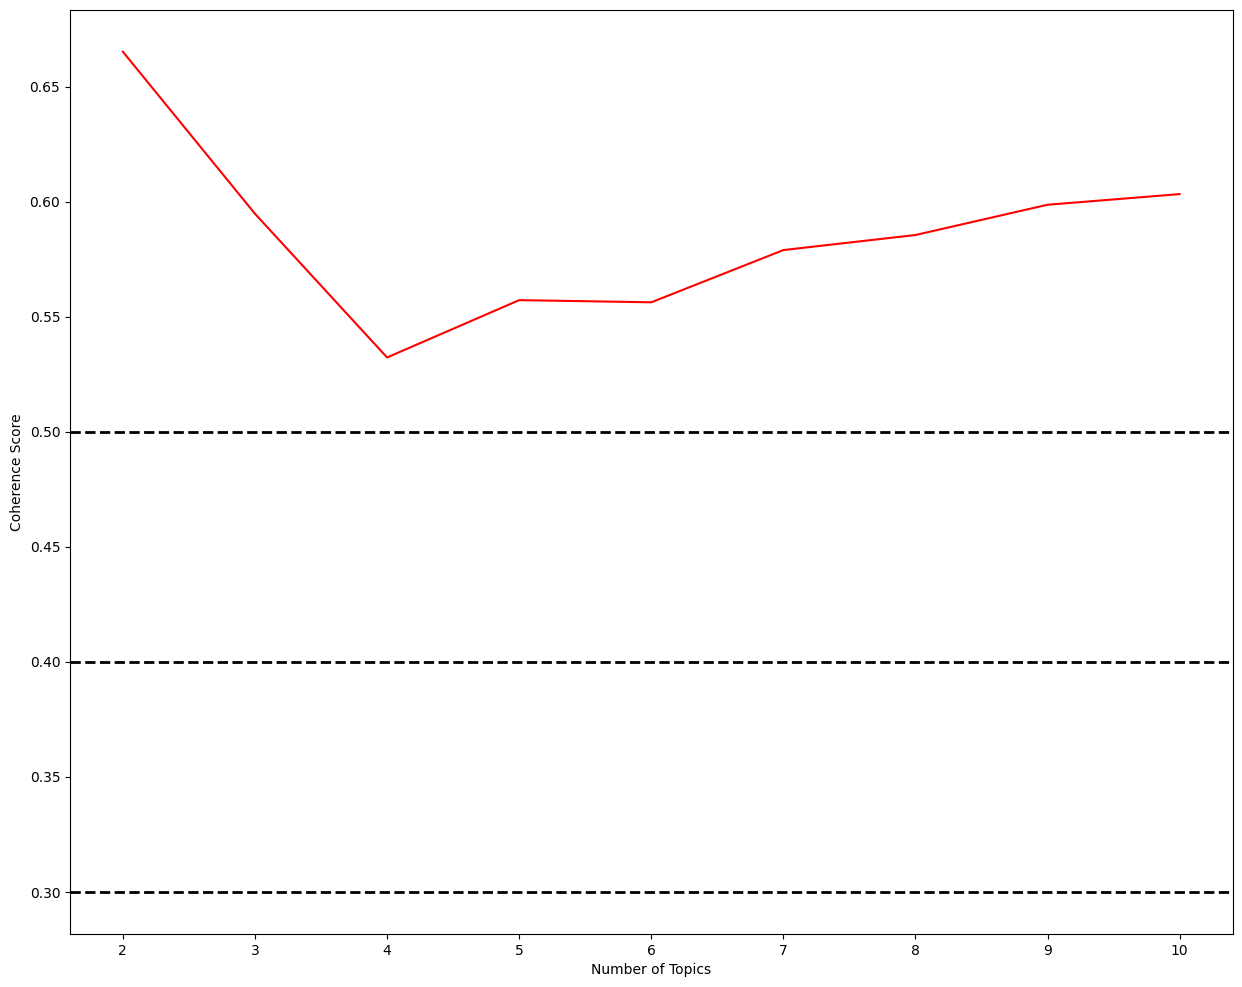

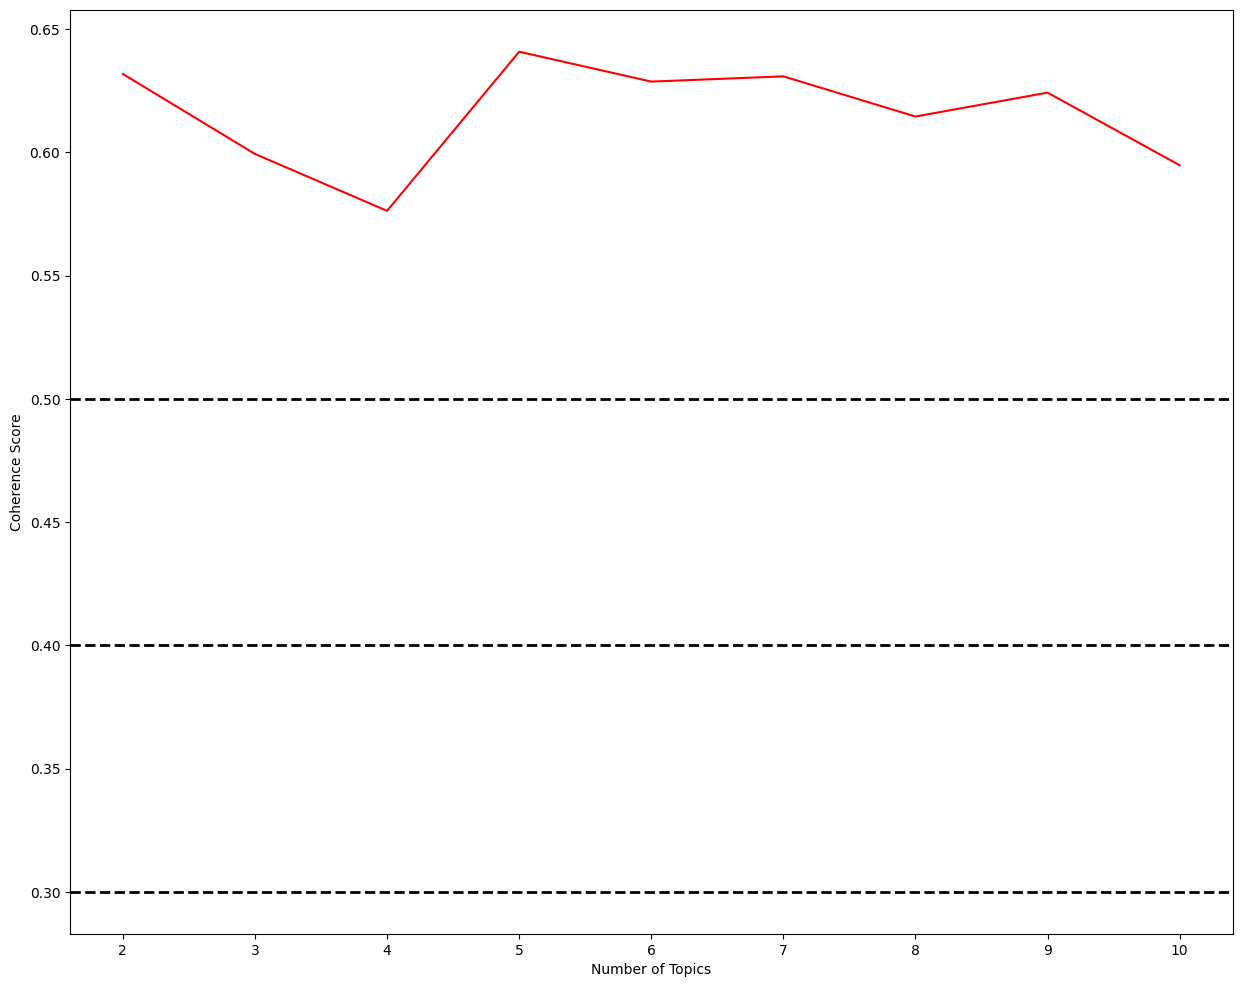

In [9]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v1"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [10]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.560773,df_pos
1,LSI,3,0.560640,df_pos
2,LSI,4,0.604348,df_pos
3,LSI,5,0.610163,df_pos
4,LSI,6,0.608739,df_pos
5,LSI,7,0.608229,df_pos
6,LSI,8,0.610296,df_pos
7,LSI,9,0.599113,df_pos
8,LSI,10,0.611375,df_pos
0,LDA,2,0.596930,df_pos


In [11]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.665202,df_neg
1,LDA,6,0.650885,df_pos


In [12]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 2

Topic 1: I, room, hotel, staff, check, stay, get, time, night, book

Topic 2: room, I, hotel, small, clean, good, bathroom, smell, bed, location

----------


DF NAME: df_pos
MODEL: LDA - NUMBER OF TOPICS: 6

Topic 1: I, stay, like, make, feel, night, room, hotel, thank, staff

Topic 2: room, clean, I, bed, small, hotel, bathroom, staff, stay, also

Topic 3: check, room, I, get, early, pool, hotel, hour, take, need

Topic 4: location, near, meet, hotel, staff, place, close, stay, restaurant, food

Topic 5: location, good, staff, hotel, room, great, clean, nice, friendly, stay

Topic 6: I, staff, hotel, book, time, room, stay, check, go, breakfast

----------



In [13]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 03:59:32.985611
Text processing spent 2:05:55.641792
